In [ ]:
#default_exp ocr_inference

In [ ]:
#export
from ocr.core import load_inference, plot
from fastai import *
from fastai.vision import *
import numpy as np
import cv2

### Example

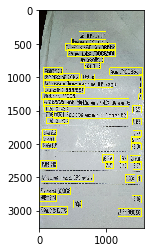

In [ ]:
from ocr.bbox_east_training import *
from ocr.bbox_east_inference import TextBBoxPredictor, show_bboxes_on_image
t = TextBBoxPredictor(model_name='east_bbox_10x3', use_gpu=False)

im = cv2.imread('../test_data/cekis_cropped.jpg')
im = im[ :, :, [2,1,0] ] # BGR -> RGB

bboxes = t.image2bboxes(tensor(im), offset=10, nms_threshold=0.2)
show_bboxes_on_image(im, bboxes)

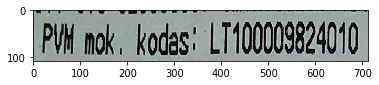

In [ ]:
for t,l,b,r in bboxes:
    text_im = im[ t:b , l:r ]
    plot(text_im)
    break

In [ ]:
#export
class OcrPredictor:
    def __init__(self):
        pass
    
    def image2text(self, image):
        pass

## CRNN

In [ ]:
#export
def decode_ctc(texts, classes):
    """ convert text-index into text-label.
    @param: list(arr[N],...) :list of arrays of size N, where N can differ between elements (elements in arr are indexes)
    @return list(arr[M],...) :same just as strings and M are always <= N
    """
    out = []
    index = 0
    for t in texts:
        char_list = []
        for i in range(len(t)):
            if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):  # removing repeated characters and blank.
                char_list.append(t[i])
        out.append(tensor(char_list))
    return out

In [ ]:
#export
from ocr.ocr_crnn_training import *

class CrnnOcrPredictor(OcrPredictor):
    def __init__(self, model_name='crnn_ocr', use_gpu=False):
        '''
        @param: str  :name of model in ../models dir
        @param: bool :use gpu? (model ~600mb)
        '''
        self.model_name, self.use_gpu = model_name, use_gpu
        if self.use_gpu: defaults.device = torch.device('cuda')
        else: defaults.device = torch.device('cpu')
        self.learner = load_inference(model_name)
        
    def image2text(self, image):
        '''
        @param: torch.arr[h,w,3] :(make sure its in RGB not BGR! and pixel range is [0-255])
        @return str              :text string
        '''
        image = Image(image.permute(2,0,1).float() / 255.)
        batch = self.learner.data.one_item(image)
        preds = self.learner.model.eval()(batch[0]).squeeze().argmax(-1)
        text = decode_ctc([preds], classes=self.learner.data.classes)[0]
        if list(text.shape) == []: return ''
        indexes = [int(i) for i in text]
        return ''.join([self.learner.data.classes[i] for i in indexes])

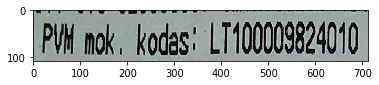

Pk lodasiIt030l0


In [ ]:
c = CrnnOcrPredictor(model_name='crnn_ocr', use_gpu=False)
plot(text_im)
text = c.image2text(tensor(text_im))
print(text)

## Tesseract

In [ ]:
#export
import pytesseract

class TesseractOcrPredictor(OcrPredictor):
    def __init__(self):
        pass
        
    def image2text(self, image, config=("-l eng --oem 1 --psm 3")):
        '''
        @param: torch.arr[h,w,3] :(make sure its in RGB not BGR! and pixel range is [0-255])
        @param: str              :tesseract config w/ params
        @return str              :text string
        '''
        return pytesseract.image_to_string(to_np(image), config=config)

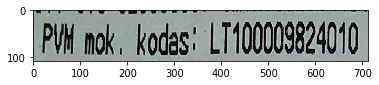

PUM mok, kodas: L7400009824040.


In [ ]:
c = TesseractOcrPredictor()
plot(text_im)
text = c.image2text(tensor(text_im))
print(text)

## Attention

In [ ]:
#export
from ocr.ocr_attention_training import *

class AttentionOcrPredictor(CrnnOcrPredictor):
    def __init__(self, model_name='attention_ocr', use_gpu=False):
        super().__init__(model_name, use_gpu)

CNN output = h:1 c:512


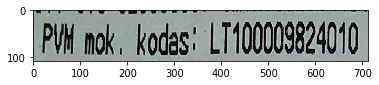

PVNM ROK, KODES: LT100009824010


In [ ]:
c = AttentionOcrPredictor(model_name='attention_ocr', use_gpu=False)
plot(text_im)
text = c.image2text(tensor(text_im))
print(text)

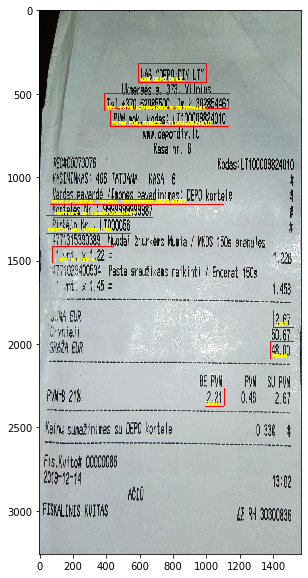

In [ ]:
out_im = im.copy()
for t,l,b,r in bboxes[:10]:
    text_im = im[ t:b , l:r ]
    text = c.image2text(tensor(text_im))
    out_im = cv2.rectangle(out_im, (l,t), (r,b), color=255, thickness=2)
    out_im = cv2.putText(out_im, text, org=(l+10,b-10), fontFace=cv2.FONT_HERSHEY_PLAIN, 
                         fontScale=2.0, color=(255,255,0), thickness=5, lineType=cv2.LINE_AA) 
plot(out_im, figsize=(10,10))

## Times

#### CRNN

In [ ]:
from ocr.ocr_crnn_training import *
from ocr.ocr_inference import CrnnOcrPredictor
text_predictor_gpu = CrnnOcrPredictor(model_name='crnn_ocr', use_gpu=True)
text_predictor_cpu = CrnnOcrPredictor(model_name='crnn_ocr', use_gpu=False)

In [ ]:
%%timeit
_ = text_predictor_cpu.image2text(tensor(text_im))

15.3 ms ± 7.06 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
_ = text_predictor_gpu.image2text(tensor(text_im))

4.8 ms ± 23.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Tesseract

In [ ]:
from ocr.ocr_inference import TesseractOcrPredictor
text_predictor_cpu = TesseractOcrPredictor()

In [ ]:
%%timeit
_ = text_predictor_cpu.image2text(tensor(text_im))

222 ms ± 1.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Attention

In [ ]:
from ocr.ocr_attention_training import *
from ocr.ocr_inference import AttentionOcrPredictor
text_predictor_gpu = AttentionOcrPredictor(model_name='attention_ocr', use_gpu=True)
text_predictor_cpu = AttentionOcrPredictor(model_name='attention_ocr', use_gpu=False)

In [ ]:
%%timeit
_ = text_predictor_cpu.image2text(tensor(text_im))

55.3 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
_ = text_predictor_gpu.image2text(tensor(text_im))

11.5 ms ± 150 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
